<a href="https://colab.research.google.com/github/notakshitgoyal/MACHINE_LEARNING/blob/main/toy_classification_and_multiclass_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
#make classification dataset fabricated
import sklearn
from sklearn.datasets import make_circles
#make 1000 samples
n_samples = 1000
X,y = make_circles(n_samples,noise=0.03,random_state=42)
len(X),len(y)

(1000, 1000)

In [111]:
#print first 5 samples
print(f"{X[:5]}\n")
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

[1 1 1 1 0]


In [112]:
#make a dataframe
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "labels":y})
circles.head(10)

,X1,X2,labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


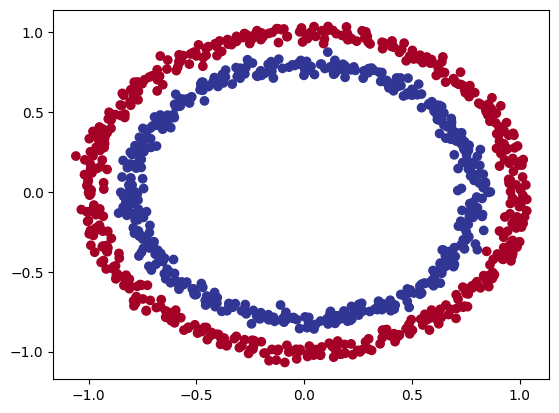

In [113]:
#visualize the data
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0],
            y= X[:,1],
            c = y,
            cmap=plt.cm.RdYlBu)

In [114]:
#check input and output shapes(most common errors)
X.shape,y.shape


((1000, 2), (1000,))

In [115]:
import torch
torch.__version__

'2.1.0+cu121'

In [116]:
#turning data into tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [117]:
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [118]:
#train test split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
len(X_train),len(X_test),len(y_train),len(y_test),n_samples

(800, 200, 800, 200, 1000)

In [119]:
#device agnostic code
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [120]:
#building a model
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)
    self.relu = nn.ReLU()
  def forward(self,x):
    return self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))))
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [121]:
#loss function
loss_fn = nn.BCEWithLogitsLoss()
#optimizer
optimizer = torch.optim.SGD(params= model_0.parameters(),lr = 0.1 )
#cal accuracy
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [122]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.0167],
        [0.0207],
        [0.0126],
        [0.0171],
        [0.0420]], device='cuda:0')

In [123]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [124]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5042],
        [0.5052],
        [0.5032],
        [0.5043],
        [0.5105]], device='cuda:0')

In [125]:
y_preds = torch.round(y_pred_probs)
y_pred_lables = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(),y_pred_lables.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

In [126]:
#traing loop
#song from Daniel Bourke
torch.manual_seed(42)
epochs = 10000
X_train,y_train,X_test,y_test = X_train.to(device),y_train.to(device),X_test.to(device),y_test.to(device)
for epoch in range(epochs):
  model_0.train()
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true = y_train,y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  model_0.eval()
  with torch.inference_mode():
    test_logits=model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true = y_test,y_pred=test_pred)
  if epoch % 1000 == 0:
    print(f"Epoch: {epoch} | Loss {loss:.5f},Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss 0.69295,Acc: 50.00 | Test loss: 0.69319, Test acc: 50.00%
Epoch: 1000 | Loss 0.65241,Acc: 60.50 | Test loss: 0.65344, Test acc: 59.00%
Epoch: 2000 | Loss 0.40864,Acc: 93.75 | Test loss: 0.43576, Test acc: 86.50%
Epoch: 3000 | Loss 0.36741,Acc: 97.62 | Test loss: 0.38346, Test acc: 94.00%
Epoch: 4000 | Loss 0.35667,Acc: 98.50 | Test loss: 0.37252, Test acc: 95.00%
Epoch: 5000 | Loss 0.35312,Acc: 99.25 | Test loss: 0.37113, Test acc: 95.50%
Epoch: 6000 | Loss 0.35139,Acc: 99.25 | Test loss: 0.36784, Test acc: 95.50%
Epoch: 7000 | Loss 0.34985,Acc: 99.88 | Test loss: 0.37413, Test acc: 95.00%
Epoch: 8000 | Loss 0.34924,Acc: 99.50 | Test loss: 0.37116, Test acc: 95.00%
Epoch: 9000 | Loss 0.34885,Acc: 99.88 | Test loss: 0.37145, Test acc: 95.00%


In [127]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


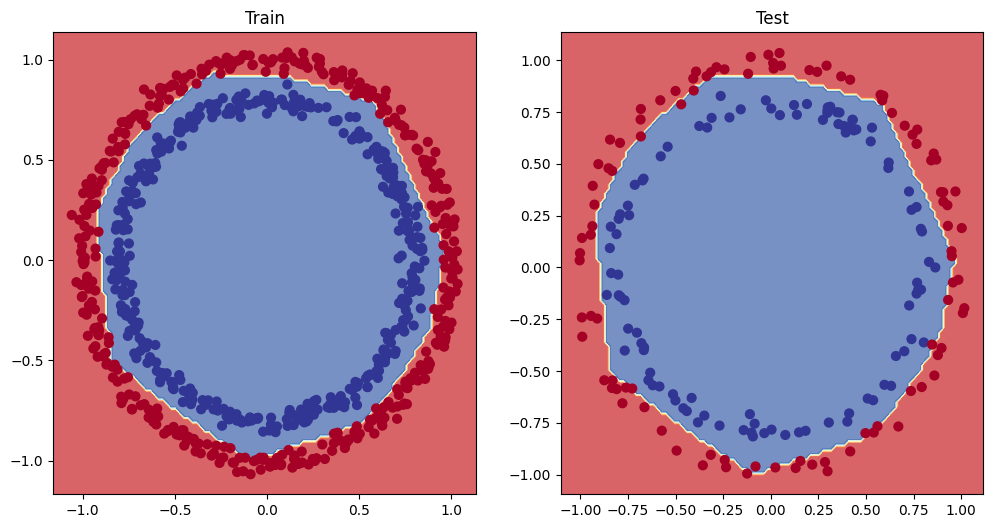

In [128]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)